In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# --- Mount Drive and Unzip Data ---
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/archive2.zip'
if os.path.exists(zip_path):
    os.makedirs('ham10000_data', exist_ok=True)
    os.system(f'unzip -q "{zip_path}" -d ham10000_data/')
    print("Unzipping completed.")
else:
    print(f"Error: Zip file not found at {zip_path}")

# --- NEW PARAMETERS for High-Resolution Training ---
base_dir = 'ham10000_data'
IMG_SIZE = 384 # Increased image resolution
BATCH_SIZE = 16 # Drastically reduced batch size to fit in memory
NUM_CLASSES = 7
EPOCHS_INITIAL = 25 # Epochs for initial training
EPOCHS_FINE_TUNE = 15 # Epochs for fine-tuning

# --- Load and Preprocess All Data (Code is the same, but uses new IMG_SIZE) ---
metadata_df = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))
metadata_df['age'].fillna(metadata_df['age'].mean(), inplace=True)
metadata_df = pd.get_dummies(metadata_df, columns=['sex', 'localization'], drop_first=True)
# ... (The rest of the data prep code is identical to the multi-modal script)
scaler = StandardScaler()
metadata_df['age'] = scaler.fit_transform(metadata_df[['age']])
image_folders = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if 'images' in f]
all_image_paths = {os.path.splitext(f)[0]: os.path.join(folder, f) for folder in image_folders for f in os.listdir(folder)}
metadata_df['image_path'] = metadata_df['image_id'].map(all_image_paths.get)
class_names = sorted(metadata_df['dx'].unique())
label_map = {label: i for i, label in enumerate(class_names)}
metadata_df['label'] = metadata_df['dx'].map(label_map.get)
train_df, val_df = train_test_split(metadata_df, test_size=0.2, random_state=42, stratify=metadata_df['label'])
meta_features = [col for col in train_df.columns if col not in ['lesion_id', 'image_id', 'dx', 'dx_type', 'image_path', 'label']]
train_meta = train_df[meta_features].astype('float32')
val_meta = val_df[meta_features].astype('float32')
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights_dict = dict(enumerate(class_weights))
def load_and_preprocess(path, meta, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return {'image_input': image, 'meta_input': meta}, label
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['image_path'], train_meta, train_df['label'])).map(load_and_preprocess, num_parallel_calls=AUTOTUNE).shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_dataset = tf.data.Dataset.from_tensor_slices((val_df['image_path'], val_meta, val_df['label'])).map(load_and_preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
print("\nHigh-resolution multi-input datasets created successfully.")

Mounted at /content/drive
Unzipping completed.


/tmp/ipython-input-3244110089.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata_df['age'].fillna(metadata_df['age'].mean(), inplace=True)



High-resolution multi-input datasets created successfully.


27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Starting Initial Training Phase (Head Only) ---
Epoch 1/25
501/501 ━━━━━━━━━━━━━━━━━━━━ 130s 207ms/step - accuracy: 0.4341 - loss: 1.6333 - val_accuracy: 0.6201 - val_loss: 1.0633
Epoch 2/25
501/501 ━━━━━━━━━━━━━━━━━━━━ 129s 194ms/step - accuracy: 0.5940 - loss: 1.1137 - val_accuracy: 0.6191 - val_loss: 1.0282
Epoch 3/25
501/501 ━━━━━━━━━━━━━━━━━━━━ 145s 201ms/step - accuracy: 0.6320 - loss: 1.0146 - val_accuracy: 0.6136 - val_loss: 1.0229
Epoch 4/25
501/501 ━━━━━━━━━━━━━━━━━━━━ 142s 201ms/step - accuracy: 0.6587 - loss: 0.9216 - val_accuracy: 0.6286 - val_loss: 1.0391
Epoch 5/25
501/501 ━━━━━━━━━━━━━━━━━━━━ 140s 196ms/step - accuracy: 0.6818 - loss: 0.8619 - val_accuracy: 0.7189 - val_loss: 0.7983
Epoch 6/25
501/501 ━━━━━━━━━━━━━━━━━━━━ 144s 201ms/step - accuracy: 0.6775 - loss: 0.8401 - val_accuracy: 0.6610 - val_loss: 0.9364
Epoch 7/25
501/501 ━━━━━━━━━━━━━━━━━━━━ 141s 199ms/step - accuracy: 0.6850 - loss: 0.8164 - val_accuracy

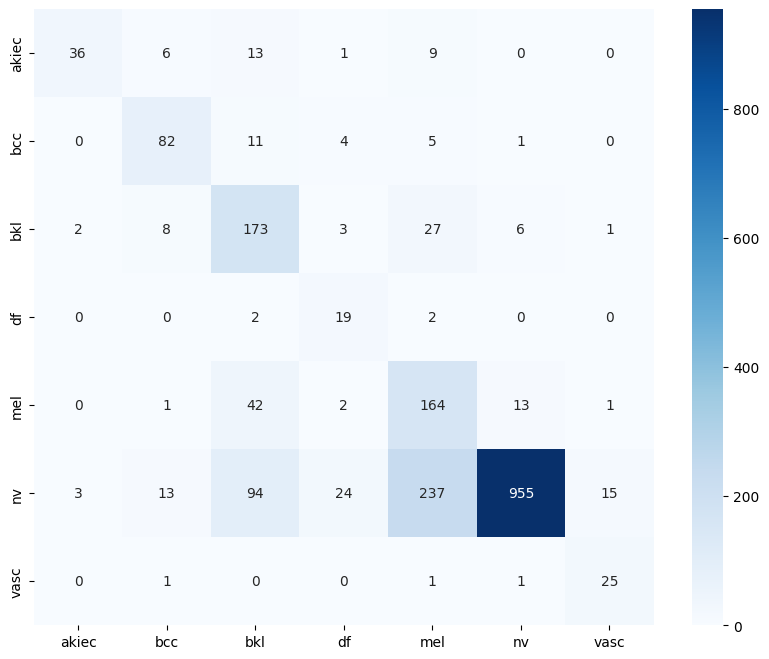

In [2]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Build Model ---
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),tf.keras.layers.RandomRotation(0.2),])
base_model = tf.keras.applications.EfficientNetB1(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False # Start with the base model frozen
image_input = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')
x_img = tf.keras.applications.efficientnet.preprocess_input(image_input)
x_img = data_augmentation(x_img)
x_img = base_model(x_img, training=False)
x_img = tf.keras.layers.GlobalAveragePooling2D()(x_img)
meta_input = tf.keras.layers.Input(shape=(len(meta_features),), name='meta_input')
x_meta = tf.keras.layers.Dense(32, activation='relu')(meta_input)
combined = tf.keras.layers.concatenate([x_img, x_meta])
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(combined)
model = tf.keras.Model(inputs=[image_input, meta_input], outputs=outputs)

# --- 2. Initial Training Phase ---
print("\n--- Starting Initial Training Phase (Head Only) ---")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_initial = model.fit(train_dataset, epochs=EPOCHS_INITIAL, validation_data=validation_dataset, class_weight=class_weights_dict, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

# --- 3. Fine-Tuning Phase ---
print("\n--- Starting Fine-Tuning Phase ---")
base_model.trainable = True
# Unfreeze the top 40 layers
fine_tune_at = len(base_model.layers) - 40
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
# Re-compile with a very low learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_fine_tune = model.fit(train_dataset, epochs=EPOCHS_INITIAL + EPOCHS_FINE_TUNE, initial_epoch=history_initial.epoch[-1], validation_data=validation_dataset, class_weight=class_weights_dict, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

# --- 4. Final Evaluation ---
print("\nStarting final evaluation...")
loss, accuracy = model.evaluate(validation_dataset)
print("\n" + "="*40)
print("     Final Results on the Validation Set")
print("="*40)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("="*40)

# Detailed Classification Report
print("\n" + "="*50)
print("     Detailed Classification Report")
print("="*50)
true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)
predictions = model.predict(validation_dataset)
predicted_labels = np.argmax(predictions, axis=1)
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

# Confusion Matrix
print("\n" + "="*50)
print("     Confusion Matrix")
print("="*50)
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.show()